**任务时间：题目1-3（11.05-11.10）
题目4、5（11.12-11.17）
题目6（11.19-11.25）**

**互评与筛选时间：题目1-3（11.11）
题目4、5（11.18）
题目6（11.26）**

每周只用提交相应的部分到自己的git，试题实行每周淘汰制

新互评链接：https://yiqixie.com/s/home/fcACT-kZRz10FXWBU2jXDt8VO

# 1、成功读取BTCUSDT:binance的数据，绘出30Min和1H的gap图

'start_date':20180601000000

In [58]:
import warnings

warnings.filterwarnings('ignore')

In [19]:
from jaqs_fxdayu.data.dataservice import LocalDataService

ds = LocalDataService()

## 加freq参数
path = r'../min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume',
         'symbol': 'BTCUSDT:binance',
         'freq': '30Min,1H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props) #读取数据

In [20]:
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv30M = HFDataView()
dv1H = HFDataView()
dv30M.create_init_dv(Time_dict['30Min'].dropna().set_index(["trade_date","symbol"]))
dv1H.create_init_dv(Time_dict['1H'].dropna().set_index(["trade_date","symbol"]))

Initialize dataview success.
Initialize dataview success.


In [61]:
Gap30 = dv30M.add_formula('gap', 'close-Delay(open, 1)',add_data=True)
Gap1H = dv1H.add_formula('gap', 'close-Delay(open, 1)',add_data=True)

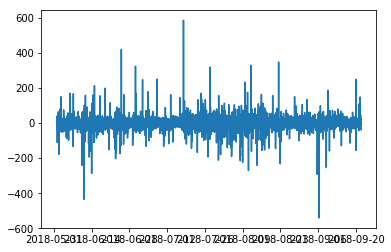

In [62]:
#30Min的图
import matplotlib.pyplot as plt
plt.plot(dv30M.get_ts('gap', date_type='datetime')['BTCUSDT:binance'])
plt.show()

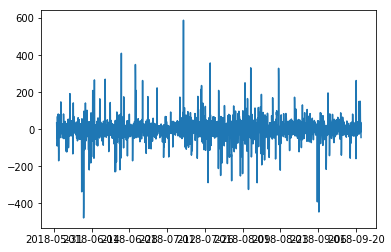

In [63]:
#1H的图
import matplotlib.pyplot as plt
plt.plot(dv1H.get_ts('gap', date_type='datetime')['BTCUSDT:binance'])
plt.show()

# 2、调用alpha101research中的alpha10进行绘图，定义事件，打印绩效

要求：

1、绘出alpha10_dv30M_ma5_ma20、alpha10_dv1H_ma5_ma20的图。

2、定义alpha10的金叉死叉事件，周期为20和55，并打印出long_short的绩效

In [64]:
#定义alpha10信号

for dvAdd in [dv30M, dv1H]:
    dvAdd.add_formula('alpha10_C','If(Ts_Min(Delta(close,1),4)>0,Delta(close,1),If((Ts_Max(Delta(close,1),4)<0),Delta(close,1),(-1*Delta(close,1))))',add_data=True)

In [65]:
#定义绘图函数
import matplotlib.pyplot as plt

def Plot_Mean(dv, alpha, chart_name='dv_alpha_ma', ShortPeriod=20, LongPeriod=60, n=0):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:])
    ax.set_title(chart_name,fontsize=24,color='b') 
    ax1.plot(alpha.iloc[n:], alpha=0.1)
    ax1.plot(pd.Series(alpha.rolling(ShortPeriod).mean(), index=alpha.index).iloc[n:])
    ax1.plot(pd.Series(alpha.rolling(LongPeriod).mean(), index=alpha.index).iloc[n:])
#     plt.savefig(chart_name)
    plt.show()

In [83]:
dv_dict = {'alpha10_dv30M':dv30M, 'alpha10_dv1H':dv1H}
alpha1_dict = {n: dv.get_ts('alpha10_C', date_type='datetime') for n, dv in dv_dict.items()}

#import pandas as pd
#for name, alpha in alpha1_dict.items():
#    Plot_Mean(globals()[name.split('_')[1]], alpha.iloc[:,0], chart_name=name+'_ma5_ma20',ShortPeriod=5, LongPeriod=20, n=-1000)#橘色短线 绿色长线
#alpha1_dict
for n, dv in dv_dict.items():
    print(n,dv)
alpha = dv30M.get_ts('alpha10_C', date_type='datetime').iloc[:,0]
type(alpha)
alpha1 = dv30M.get_ts('alpha10_C', date_type='datetime')
type(alpha1)

alpha10_dv30M <jaqs_fxdayu.data.hf_dataview.HFDataView object at 0x000001916F6AD208>
alpha10_dv1H <jaqs_fxdayu.data.hf_dataview.HFDataView object at 0x000001916F6ADFD0>


pandas.core.frame.DataFrame

In [14]:
# 进场信号
long = dv1H.add_formula("longAlpha10","If((Ts_Mean(alpha10_C,20)>Ts_Mean(alpha10_C,55)) && (Delay(Ts_Mean(alpha10_C,20),1)<=Delay(Ts_Mean(alpha10_C,55),1)),2,0)", add_data=True)
short = dv1H.add_formula("shortAlpha10","If((Ts_Mean(alpha10_C,20)<Ts_Mean(alpha10_C,55)) && (Delay(Ts_Mean(alpha10_C,20),1)>=Delay(Ts_Mean(alpha10_C,55),1)),-2,0)", add_data=True)

# 出场信号
close_long = dv1H.add_formula("closeLongAlpha10","If(shortAlpha10==-2,1,0)", add_data=True)
close_short = dv1H.add_formula("closeShortAlpha10","If(longAlpha10==2,-1,0)", add_data=True)

dv1H.get_ts('longAlpha10').stack()[dv1H.get_ts('longAlpha10').stack()==2].tail()

Field [longAlpha10] is overwritten.
Field [shortAlpha10] is overwritten.
Field [closeLongAlpha10] is overwritten.
Field [closeShortAlpha10] is overwritten.


trade_date      symbol         
20180919050000  BTCUSDT:binance    2.0
20180919080000  BTCUSDT:binance    2.0
20180919110000  BTCUSDT:binance    2.0
20180919160000  BTCUSDT:binance    2.0
20180920230000  BTCUSDT:binance    2.0
dtype: float64

In [17]:
#通过测试报告，看多空信号的绩效，这里是定义报告格式
from jaqs_fxdayu.research import TimingDigger

tdMa = TimingDigger(output_folder=".", output_format='pdf',signal_name='Ma')

def TimingSignal(td, dv, long='long', short='short',closeLong='closeLong', closeShort='closeShort'\
                 , mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

from jaqs_fxdayu.research import TimingDigger

tdAlpha10 = TimingDigger(output_folder=".", output_format='pdf',signal_name='Alpha10')

TimingSignal(tdAlpha10, dv1H,'longAlpha10','shortAlpha10','closeLongAlpha10','closeShortAlpha10', 100, 0.05, 0.3)

tdAlpha10.create_event_report(sig_type="long_short")

Nan Data Count (should be zero) : 0;  Percentage of effective data: 6%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 6%
*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat                8.290   -9.095   -0.145
p-value               0.000    0.000    0.885
mean                  0.011   -0.011   -0.000
std                   0.016    0.015    0.019
info_ratio            0.677   -0.738   -0.008
skewness              3.664   -1.974    0.697
kurtosis             17.554    2.909    8.470
pct5                  0.001   -0.049   -0.032
pct25                 0.002   -0.012   -0.005
pct50                 0.005   -0.005   -0.000
pct75                 0.012   -0.002    0.005
pct95                 0.041   -0.001    0.027
occurance           151.000  153.000  304.000
win_ratio               NaN      NaN    0.497
win_mean/loss_mean      NaN      NaN    0.984


# 3、打印出Morningstar事件的时间点，绘出Morningstar与成交量的图

数据类型要求：'symbol': 'BTCUSDT:binance',

'freq': '1H','start_date':20180601000000

In [18]:
import warnings
warnings.filterwarnings('ignore')
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
start = time()

path = r'../min_data/VnTrader_1Min_Db'
props = {'fields':'open,high,low,close,volume',
         'symbol': 'BTCUSDT:binance',
        'freq': '1H',
        'start_date':20180601000000}
Time_dict = ds.bar_reader(path,props)
dv1H = HFDataView()
dv1H.create_init_dv(Time_dict.dropna().set_index(["trade_date","symbol"]))

Initialize dataview success.


In [19]:
morningstar = dv1H.add_formula('morningstar',"If((Ta('CDLMORNINGSTAR', 0, open, high, low, close, volume)==100),100,0)", add_data=True)
morningstarVolume = dv1H.get_ts('morningstar', date_type='datetime')
morningstarVolume[morningstarVolume['BTCUSDT:binance']==100]

symbol,BTCUSDT:binance
trade_date,
2018-06-15 22:00:00,100.0
2018-07-12 11:00:00,100.0
2018-07-19 06:00:00,100.0
2018-08-09 17:00:00,100.0
2018-08-31 04:00:00,100.0
2018-09-11 02:00:00,100.0
2018-09-18 01:00:00,100.0
2018-09-19 09:00:00,100.0


In [20]:
from matplotlib.pylab import date2num
Time_dict = ds.bar_reader(path,props)
data1H = Time_dict.set_index('datetime')

data1H['candleTime'] = list(map(date2num, data1H.index))
candle = data1H.reindex_axis(["candleTime", "open", "high", "low", "close"], 1).values

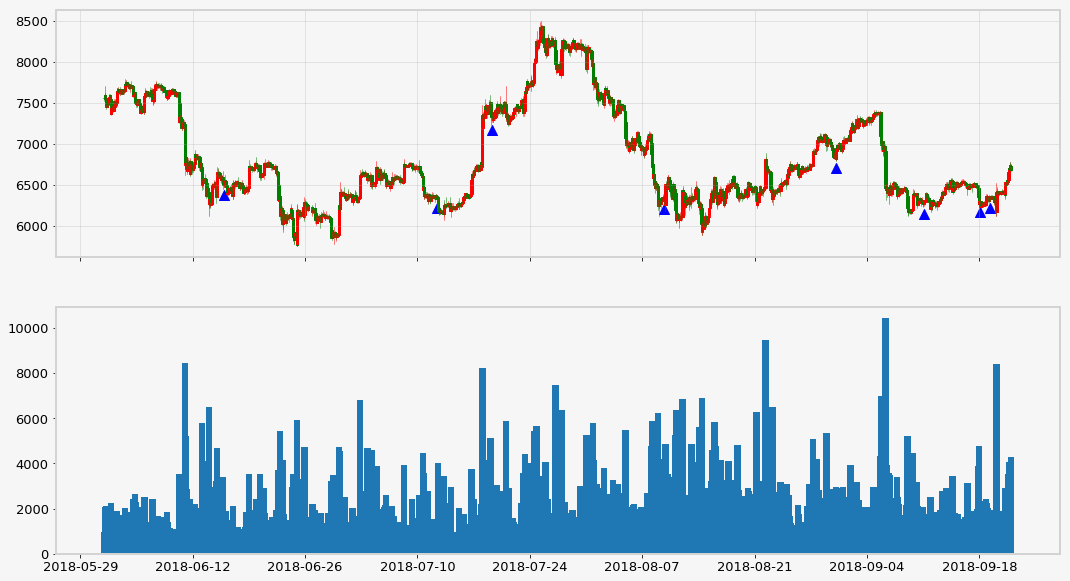

In [23]:
import mpl_finance as mpf
morningstarVolumeX = morningstarVolume[morningstarVolume['BTCUSDT:binance']==100].index

morningstarVolumeY = data1H.loc[morningstarVolumeX].low-100
def draw_candle(candle, scatterX, scatterY):
    fig, (ax, ax1) = plt.subplots(2,1,sharex=True, figsize=(18,10))
    ax.grid(True)
    mpf.candlestick_ohlc(ax, candle, width=0.3, colorup='r', colordown='g',alpha=1.0)
    ax.scatter(scatterX, scatterY, color='b', s=100, marker='^')
    ax.xaxis_date ()
    ax1.bar(data1H.index, data1H.volume)
    plt.show()
draw_candle(candle, morningstarVolumeX, morningstarVolumeY)

# 4、调用alpha101、alpha191、技术因子、candleresearch或者自己创造衍生因子，要求：任意两个因子，进行画图观察，主要例子看alpha101research和candleresearch，写研究报告（画了什么因子，思考了什么现象，对现象进行描述）


https://github.com/ChannelCMT/formula/wiki

数据类型和周期自定


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from jaqs_fxdayu.data.dataservice import LocalDataService
from jaqs_fxdayu.data.hf_dataview import HFDataView
ds = LocalDataService()

## 加freq参数
path = r'../min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume',
         'symbol': 'EOSUSDT:binance',
         'freq': '1H',
         'start_date':20180601000000}
Time_dict = ds.bar_reader(path,props) #读取数据
dv = HFDataView()
dv.create_init_dv(Time_dict.dropna().set_index(["trade_date","symbol"]))

Initialize dataview success.


In [ ]:
Time_dict.keys()

In [4]:
#定义第一个因子MACD
dv.add_formula('EMA12', "Ta('EMA',0,0,0,0,close,0,12)", add_data = True);
dv.add_formula('EMA26', "Ta('EMA',0,0,0,0,close,0,26)", add_data = True);
dv.add_formula('DIF', "EMA12 - EMA26", add_data = True);
dv.add_formula('DEA', "Ta('EMA',0,0,0,0,DIF,9)", add_data = True);
dv.add_formula('MACD', "2*(DIF-DEA)", add_data = True);

In [ ]:
#对MACD绘图
import matplotlib.pyplot as plt
import pandas as pd
fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
ax.plot(dv.get_ts('close', date_type='datetime').iloc[:,0])
ax.set_title('close',fontsize=24,color='b') 
ax1.plot(dv.get_ts('DIF', date_type='datetime').iloc[:,0],'y',label='EMA12')
ax1.plot(dv.get_ts('DEA', date_type='datetime').iloc[:,0],'k',label='EMA26')
ax1.plot(dv.get_ts('MACD', date_type='datetime').iloc[:,0],'r',label='MACD')
ax1.set_title('MACD',fontsize=24,color='b')
ax1.legend()
plt.show()

因子：
MACD指标是趋势类指标，反映了价格的变化趋势。相关中间变量的计算如下：
EMA12: 12日指数平均；
EMA26: 26日指数平均；
DIF：EMA12-EMA26；
DEA：DIF的9日指数平均；
MACD：2*（DIF-DEA）
DIF和MACD的值及线的位置
1、当DIF和MACD均大于0并向上移动时，一般表示为股市处于多头行情中，可以买入或持股；
2、当DIF和MACD均小于0并向下移动时，一般表示为股市处于空头行情中，可以卖出股票或观望。
3、当DIF和MACD均大于0但都向下移动时，一般表示为股票行情处于退潮阶段，股票将下跌，可以卖出股票和观望；
4、DIF和MACD均小于0时但向上移动时，一般表示为行情即将启动，股票将上涨，可以买进股票或持股待涨。
现象：
DIF趋势滞后；该均值趋势法可以采用金叉死叉思路进行进出场的判断信号。

In [4]:
#定义第二个因子,该因子无法用数学表达式表达，ANN模型进行计算
#在定义第二个因子时，我们通过机器学习来进行判断次日的涨幅是否可以唱过2%，或者涨幅低于-2%。
#如果涨幅超过2%，则全仓买入；如果涨幅处于-2%~2%之间，则不调仓；如果涨幅小于-2%,则平仓
#选取的特征值是，前4日开高低收，成交量相当于除以各自平均值的大小
#判断标准是，Y=0，1,2.
#为避免使用未来函数，平均数仅采用训练组的平均数

#之前的BTCUSDT有260组数据，取了200组数据训练，60组数据验证，对于EOSUSDT从113组数据中选取了100组数据用于训练，13组数据用于验证

#重新读取数据
from jaqs_fxdayu.data.hf_dataview import HFDataView
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from jaqs_fxdayu.data.dataservice import LocalDataService
from jaqs_fxdayu.data.hf_dataview import HFDataView
ds = LocalDataService()
path = r'../min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume',
         'symbol': 'EOSUSDT:binance',
         'freq': '1D',
         'start_date':20180101000000}
Time_dict = ds.bar_reader(path,props)
dv = HFDataView()
dv.create_init_dv(Time_dict.dropna().set_index(["trade_date","symbol"]))

Initialize dataview success.


In [5]:

#数据预处理
import numpy as np
data_open = dv.get_ts('open',date_type='datetime')['EOSUSDT:binance']
data_open.name = 'open'
data_open = data_open/data_open.mean()

data_high = dv.get_ts('high',date_type='datetime')['EOSUSDT:binance']
data_high.name = 'high'
data_high = data_high/data_high.iloc[0:100].mean()

data_low = dv.get_ts('low',date_type='datetime')['EOSUSDT:binance']
data_low.name = 'low'
data_low = data_low/data_low.iloc[0:100].mean()

data_close = dv.get_ts('close',date_type='datetime')['EOSUSDT:binance']
data_close.name = 'close'
data_close = data_close/data_close.iloc[0:100].mean()

data_volume = dv.get_ts('volume',date_type='datetime')['EOSUSDT:binance']
data_volume.name = 'volume'
data_volume = data_volume/data_volume.iloc[0:100].mean()

data_return = dv.get_ts('close',date_type='datetime')['EOSUSDT:binance'].pct_change()
data_return.name = 'return'

df = pd.concat([data_open, data_high, data_low, data_close, data_volume, data_return], axis = 1)
df = df.fillna(method='backfill')

In [6]:
#提取用于训练ANN的特征,共5*4 = 20个，放置在一个数组中
data_features = np.zeros((len(df)-4, 4, 5))
data_labels = np.zeros((len(df)-4))
up = 0.02
down = -0.02
for i in range(0, data_features.shape[0]):
    data_features[i] = [[df.iloc[i,0],df.iloc[i,1],df.iloc[i,2],df.iloc[i,3],df.iloc[i,4]],
                   [df.iloc[i+1,0],df.iloc[i+1,1],df.iloc[i+1,2],df.iloc[i+1,3],df.iloc[i+1,4]],
                   [df.iloc[i+2,0],df.iloc[i+2,1],df.iloc[i+2,2],df.iloc[i+2,3],df.iloc[i+2,4]],
                   [df.iloc[i+3,0],df.iloc[i+3,1],df.iloc[i+3,2],df.iloc[i+3,3],df.iloc[i+3,4]]
                   ]
    if df.iloc[i+4,5] > up:
        data_labels[i] = 2
    elif df.iloc[i+4,5] < down:
        data_labels[i] = 0
    else:
        data_labels[i] = 1

train_features = data_features[0:100]
train_labels = data_labels[0:100]

test_features = data_features[100:]
test_labels = data_labels[100:]


In [7]:
test_labels

array([1., 1., 0., 1., 2., 1., 2., 1., 0., 2., 1., 2., 2.])

In [9]:
#调用之前设计好的模型
import tensorflow as tf
from tensorflow import keras
new_model = keras.models.load_model('my_model_EOSUSDT.h5')
new_model.compile(optimizer=tf.train.AdamOptimizer(),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
test_loss, test_acc = new_model.evaluate(test_features, test_labels)
print('Test accuracy:', test_acc)

13/13 [==============================] - 0s 4ms/step
Test accuracy: 0.4615384638309479


In [11]:
#计算因子值，因子值为0,1,2的概率
import copy
predictions = new_model.predict(data_features)
actions = copy.deepcopy(predictions)
for i in range(0,predictions.shape[0]):
    actions[i,np.argmax(actions[i])] = 1 
print(actions[-60:])

[[1.         0.3392322  0.30770534]
 [1.         0.33285952 0.31786153]
 [1.         0.3174674  0.3373659 ]
 [1.         0.29911476 0.32907894]
 [1.         0.31940052 0.317366  ]
 [1.         0.31182486 0.31316945]
 [1.         0.31869718 0.30606106]
 [1.         0.33143318 0.30956146]
 [1.         0.3376386  0.3145706 ]
 [1.         0.31237125 0.3109082 ]
 [1.         0.32926846 0.30794182]
 [1.         0.33865342 0.30886856]
 [1.         0.31865913 0.31209072]
 [0.3401472  1.         0.31007957]
 [1.         0.3263509  0.32873958]
 [1.         0.30439916 0.33052883]
 [0.33056659 1.         0.33229774]
 [1.         0.3197349  0.33634412]
 [1.         0.30280852 0.33106813]
 [0.32580012 0.31603673 1.        ]
 [0.33489758 0.30760092 1.        ]
 [0.3355702  0.30715862 1.        ]
 [0.30568972 0.31767884 1.        ]
 [0.32293612 0.3020004  1.        ]
 [0.32316118 0.3002576  1.        ]
 [0.30400315 0.30923566 1.        ]
 [0.31688315 0.29753965 1.        ]
 [1.         0.28875294 0.33

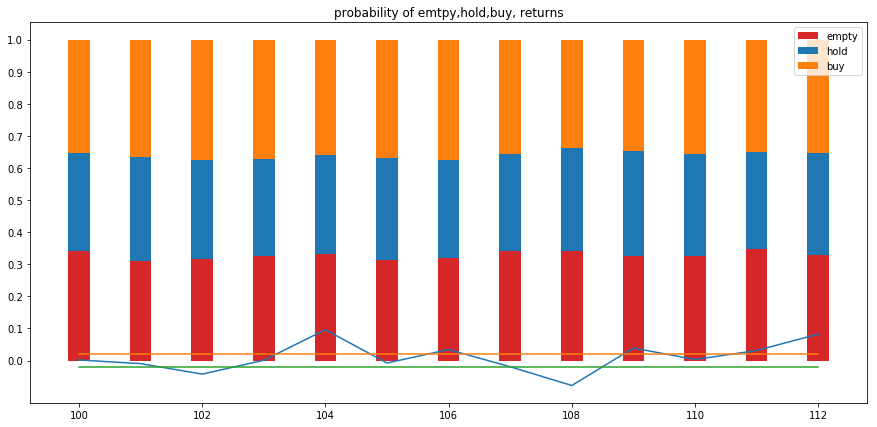

In [14]:
#观察后13天的预测结果对不对
import matplotlib.pyplot as plt
empty = predictions[-13:,0]
hold = predictions[-13:,1]
buy = predictions[-13:,2]
N = predictions.shape[0]
ind = np.arange(N)
width = 0.35
plt.figure(figsize=(15,7))
p1 = plt.bar(ind[-13:], empty, width, color='#d62728')
p2 = plt.bar(ind[-13:], hold, width,bottom=empty)
p3 = plt.bar(ind[-13:], buy, width,bottom=empty+hold)
plt.title('probability of emtpy,hold,buy, returns')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend((p1[0], p2[0], p3[0]), ('empty', 'hold', 'buy'))
plt.plot(ind[-13:],df['return'].iloc[-13:].values)
plt.plot(ind[-13:],np.ones(13)*up)
plt.plot(ind[-13:],np.ones(13)*down)
plt.show()

# 5、观察两个因子，和价格图有什么联系，如果是蜡烛图，和成交量有什么联系，怎么找到相应的信号，提出自己信号进出场的假设。（分别完成两个因子的信号假设）

信号进出场假设：可以借鉴MastatiscResearch，但不要将思路假设局限在均线上，可以观察大盘上的其他现象来写信号假设，也可以进行同时满足多个因子的信号来设计信号假设等等。

此处需要说出联系、找到的信号、你的信号进出场假设是什么

MACD信号

基于上述对MACD的分析，可以参考其意义定义下面的入场和出场条件
进场：当DIFF与DEA都在零线以上，DIFF向上突破DEA时，表明股市处于一种强势之中，股价将再次上涨，可以加码买进股票或持股待涨。
出场：当DIFF和DEA都在零线以下，DIFF向下突破DEA时，表明股市为弱势市场，股价跌势未止，应继续平仓持币。



ANN信号

ANN信号，因为数据量较小，所以仅仅能保证0.46左右识别率，虽然高于1/3=0.33，但是该识别率仍然较差。并且由于ANN的初始值使用随机函数生成，所以该ANN模型在结构和参数上都与之前的BTCUSDT:binance不同。该ANN模型保存为my_model_EOSUSDT.hd5
结果基本为一直空仓，或者持仓，过于保守；当阈值减小时，识别率会下降，但是buy的操作相对来说会增加，有利于利用涨幅进行收入。
所以该ANN信号的关键，在于设立合理的涨跌幅阈值，来保证一定的识别正确率的同时，保证可以进行相应的买入和卖出操作。
进场：ANN信号为2；
持仓：ANN信号为1；
出场：ANN信号为0.
最终终win_ratio大于0.5的原因：根据之前的分析，较低的收益率识别概率，以及在决定进出场时候的二次处理，使得收益结果具有极大的不确定性。由于测试结果仅仅为后面验证集中的17天，数据的有限性是该结果与分析不相符的主要原因。

# 6、将你的其中一个假设落实，如果能完成两个更好，但不强求

利用TimingSignal最后输出long、short、long_short这三个绩效表出来


In [5]:
#MACD定义出场信号
Long = dv.add_formula('Long_MACD','If((MACD>0) && (Delay(MACD,1)<=0),2,0)',add_data = True)    
Short = dv.add_formula('Short_MACD','If((MACD<=0) && (Delay(MACD,1)>0),-2,0)',add_data = True)  
#出场信号
Close_long = dv.add_formula('Close_Long_MACD','If(Long_MACD==-2,1,0)',add_data = True)
Close_short = dv.add_formula('Close_Short_MACD','If(Short_MACD==2,-1,0)',add_data = True)

dv.get_ts('Long_MACD').stack()[dv.get_ts('Long_MACD').stack()==2]
dv.get_ts('Short_MACD').stack()[dv.get_ts('Short_MACD').stack()==2]

Series([], dtype: float64)

In [6]:
#输出MACD绩效
from jaqs_fxdayu.research import TimingDigger

td_MACD = TimingDigger(output_folder=".", output_format='pdf',signal_name='MACD')

def TimingSignal(td, dv, long='Long_MACD', short='Short_MACD',closeLong='Close_Long_MACD', closeShort='Close_Short_MACD'\
                 , mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )
TimingSignal(td_MACD , dv, mhp=100, sl=0.05, sp=0.3)#调取数据

C:\ProgramData\Anaconda3\lib\site-packages\jaqs\research\signaldigger\plotting.py:10: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File

Nan Data Count (should be zero) : 0;  Percentage of effective data: 2%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 2%


In [7]:
td_MACD.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               5.518 -27.189  -0.254
p-value              0.000   0.000   0.800
mean                 0.104  -0.062  -0.003
std                  0.087   0.014   0.096
info_ratio           1.204  -4.354  -0.032
skewness             1.231   0.786   1.633
kurtosis             0.354   4.774   2.159
pct5                 0.015  -0.085  -0.084
pct25                0.053  -0.067  -0.062
pct50                0.072  -0.061  -0.054
pct75                0.130  -0.055   0.053
pct95                0.299  -0.052   0.196
occurance           22.000  40.000  62.000
win_ratio              NaN     NaN   0.355
win_mean/loss_mean     NaN     NaN   1.677


In [8]:
td_MACD.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               9.258 -18.560   2.485
p-value              0.000   0.000   0.016
mean                 0.154  -0.065   0.040
std                  0.091   0.020   0.127
info_ratio           1.690  -3.231   0.311
skewness            -0.109   0.257   0.672
kurtosis            -1.220   1.194  -1.040
pct5                 0.017  -0.099  -0.094
pct25                0.059  -0.075  -0.062
pct50                0.167  -0.062  -0.030
pct75                0.215  -0.053   0.166
pct95                0.292  -0.044   0.275
occurance           31.000  34.000  65.000
win_ratio              NaN     NaN   0.477
win_mean/loss_mean     NaN     NaN   2.370


In [9]:
td_MACD.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                       win    loss      all
t-stat              10.387 -31.389    1.829
p-value              0.000   0.000    0.070
mean                 0.134  -0.064    0.019
std                  0.093   0.017    0.115
info_ratio           1.440  -3.674    0.163
skewness             0.387   0.340    1.074
kurtosis            -1.149   2.562   -0.097
pct5                 0.014  -0.095   -0.087
pct25                0.054  -0.069   -0.062
pct50                0.116  -0.061   -0.052
pct75                0.209  -0.054    0.075
pct95                0.301  -0.051    0.248
occurance           53.000  74.000  127.000
win_ratio              NaN     NaN    0.417
win_mean/loss_mean     NaN     NaN    2.102


In [15]:
#定义ANN进出场信号

long = np.zeros(N)
short = np.zeros(N)
closeLong = np.zeros(N)
closeShort = np.zeros(N)
for i in range(0,N):
    long[i] = 2 if np.argmax(predictions[i])==2 else 0
    short[i] = -2 if np.argmax(predictions[i])==0 else 0
    closeLong[i] = 1 if short[i]==-2 else 0
    closeShort[i] = -1 if long[i]==2 else 0
dict_long = {'long':np.append([2,2,2,2],long)}
dict_short ={'short':np.append([0,0,0,0],short)}
dict_closeLong = {'close_long':np.append([0,0,0,0],closeLong)}
dict_closeShort ={'close_short':np.append([-1,-1,-1,-1],closeShort)}

In [16]:
close = dv.get_ts("close_adj").dropna(how='all', axis=1)
long = dv.append_df(pd.DataFrame(dict_long,index = close.index),"long")
short = dv.append_df(pd.DataFrame(dict_short,index = close.index),"short")
closeLong = dv.append_df(pd.DataFrame(dict_closeLong,index = close.index),"closeLong")
closeShort = dv.append_df(pd.DataFrame(dict_closeShort,index = close.index),"closeShort")

In [17]:
#计算ANN信号的绩效，参数经过反复调整得到
from jaqs_fxdayu.research import TimingDigger

tdANN = TimingDigger(output_folder=".", output_format='pdf',signal_name='ANN')

def TimingSignal(td, dv, long='long', short='short',closeLong='closeLong', closeShort='closeShort'\
                 , mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

C:\ProgramData\Anaconda3\lib\site-packages\jaqs\research\signaldigger\plotting.py:10: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File

In [18]:
TimingSignal(tdANN, dv, mhp=100, sl=0.05, sp=0.3)#调取数据

Nan Data Count (should be zero) : 0;  Percentage of effective data: 32%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 61%


In [20]:
tdANN.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat               4.608 -10.013   1.425
p-value              0.000   0.000   0.163
mean                 0.142  -0.083   0.035
std                  0.134   0.034   0.150
info_ratio           1.057  -2.429   0.234
skewness             0.755  -0.055   1.068
kurtosis            -0.878  -1.126   0.170
pct5                 0.009  -0.134  -0.127
pct25                0.035  -0.108  -0.073
pct50                0.079  -0.076   0.008
pct75                0.226  -0.061   0.087
pct95                0.394  -0.032   0.368
occurance           20.000  18.000  38.000
win_ratio              NaN     NaN   0.526
win_mean/loss_mean     NaN     NaN   1.705


In [21]:
tdANN.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                       win    loss     all
t-stat              21.722  -9.212   6.016
p-value              0.000   0.000   0.000
mean                 0.277  -0.081   0.136
std                  0.083   0.046   0.189
info_ratio           3.352  -1.773   0.719
skewness            -1.573  -0.521  -0.248
kurtosis             2.025   0.695  -1.655
pct5                 0.136  -0.137  -0.124
pct25                0.234  -0.114  -0.061
pct50                0.308  -0.072   0.214
pct75                0.328  -0.054   0.318
pct95                0.355  -0.007   0.345
occurance           43.000  28.000  71.000
win_ratio              NaN     NaN   0.606
win_mean/loss_mean     NaN     NaN   3.409


In [22]:
tdANN.create_event_report(sig_type="long_short") #同时计算多空头信号的绩效

*****-Summary-*****
Event Analysis
                       win    loss      all
t-stat              15.394 -13.192    5.727
p-value              0.000   0.000    0.000
mean                 0.234  -0.082    0.101
std                  0.120   0.042    0.183
info_ratio           1.955  -1.967    0.551
skewness            -0.702  -0.417    0.164
kurtosis            -0.912   0.596   -1.587
pct5                 0.014  -0.138   -0.125
pct25                0.152  -0.112   -0.065
pct50                0.294  -0.073    0.041
pct75                0.325  -0.055    0.304
pct95                0.368  -0.016    0.352
occurance           63.000  46.000  109.000
win_ratio              NaN     NaN    0.578
win_mean/loss_mean     NaN     NaN    2.855
